## Estimation of Batting Averages using baseball statistics


### Introduction

In the journal entry for week 6, I intend to explore empirical bayes estimation to help a base ball recruiter trying to make a decision on who out of the potential players is a better batter based on the no. of hits they get.

Imagine, one player accomplished 4 hits out of 10 chances and another one 300 hits out of 1000 chances. Who is a better player? 

Historical baseball statistics say that a typical player gets a hit around 27% of the time.

In the above case, while the first player has a higher score, there is not a lot of evidence. His hits could be totally due to luck. The second player's score looks more realistic and actually better than an average score, as a typical player gets a hit around 27% of the time.

So, to help the baseball recruiter make a more realistic decision about the potential player's , I will be diving into the Lahman's database to predict batting averages using empirical bayes estimation.

Batting average(BA) is defined as the no. times a player gets a base hit(H) divided by no. of times he goes up at-bat(AB).

### Load the required data

In [277]:
# Import the libraries and load the dataset
library(dplyr)
library(tidyr)
library(Lahman)

In [281]:
# Loading, merging and formating the dataset in required form. 
data <-Batting %>%
 filter(AB>0) %>%
 anti_join(Pitching,by='playerID') %>%
 group_by(playerID) %>%
 summarize(H = sum(H), AB = sum(AB)) %>%
 mutate(BA = H/AB)


# Fetch the names of the players
data <-Master %>%
      tbl_df() %>%
      select(playerID,nameFirst,nameLast) %>%
      unite(name,nameFirst,nameLast,sep=" ") %>%
      inner_join(data,by='playerID') %>%
      select(-playerID)

Let's take a look at the best batters in the history. The ones with highest batting average!!

In [282]:
head(data[order(-data$BA),])

name,H,AB,BA
Jeff Banister,1,1,1
Doc Bass,1,1,1
Steve Biras,2,2,1
C. B. Burns,1,1,1
Jackie Gallagher,1,1,1
Roy Gleason,1,1,1


I would bet they are not the best batters. They are the ones that got lucky once or twice. Let's take a look at the batters with the lowest batting average.

In [283]:
head(data[order(data$BA),])

name,H,AB,BA
Frank Abercrombie,0,4,0
Lane Adams,0,3,0
Horace Allen,0,7,0
Pete Allen,0,4,0
Walter Alston,0,1,0
Bill Andrus,0,9,0


The worst batter's batting average looks really bad!!!

### Methods

Let's use beta distribution to represent our prior expectations and update based on new evidence to predict a more practical batting average of the players.

### Estimate a beta prior from the data

The first step in empirical bayes is to estimate a beta prior using the data. Prior estimation from the data might not be a typical bayesian approach. There is a lot of discussion around when it might be appropriate to use empirical bayesian approach. It actually depends on the size of the data. If the we have a lot of data, we can get a fairly good prior estimate that will not depend on any one player. 

Therefore, I will go ahead and use beta distribution to estimate the prior.

Let's filter out the noisy cases i.e get rid of players with at-bats less than 500 and look at the distribution of batting averages across all players in the data.

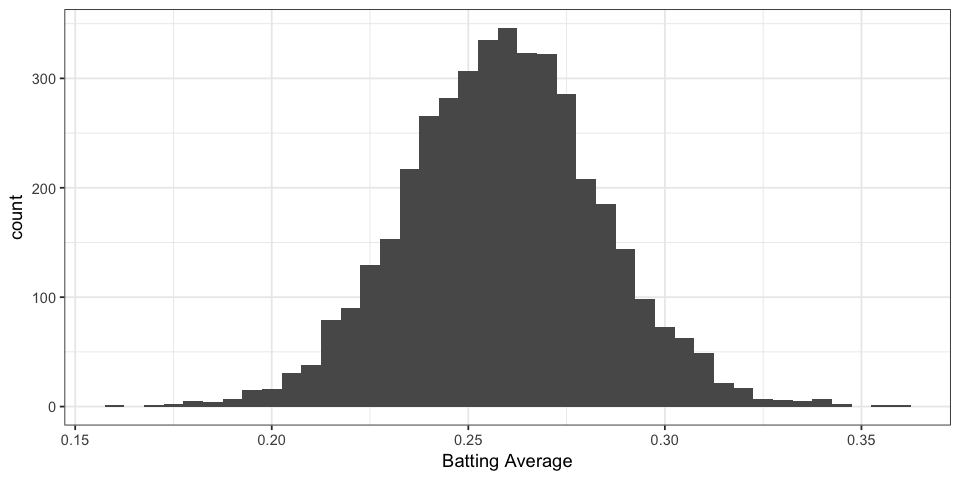

In [285]:
#Setting the plot figure size
options(repr.plot.width=8, repr.plot.height=4)

# plotting the batting averages across all players with at-bats>=500
data %>%
  filter(AB >= 500) %>%
  ggplot(aes(BA)) +
  geom_histogram(binwidth = .005)+
  xlab('Batting Average')

The distribution looks unimodal. So, we can fit the following model...

$$X\sim\mbox{Beta}(\alpha_0,\beta_0)$$

However, if the distribution had more than 1 peak, we might need a more complicated model.


Let's focus on the player's with at-bats>=500 for the modeling purpose as well. We can use fitdistr function from MASS library to fit the model.


Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”Warning message in densfun(x, parm[1], parm[2], ...):
“NaNs produced”

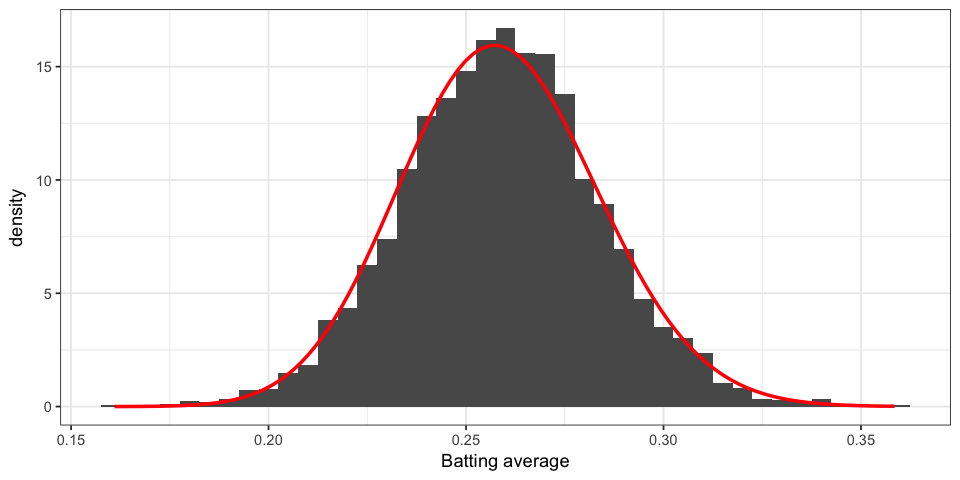

In [286]:
# Filter out the players
df <- data %>%
    filter(AB >= 500)


# Fit the model using fitdistr
m <- MASS::fitdistr(df$BA, dbeta,
                    start = list(shape1 = 1, shape2 = 10))

alpha0 <- m$estimate[1]
beta0 <- m$estimate[2]

# plotting to see how well the model fits the data
df %>%
  filter(AB >= 500) %>%
  ggplot() +
  geom_histogram(aes(BA, y = ..density..), binwidth = .005) +
  stat_function(fun = function(x) dbeta(x, alpha0, beta0), color = "red",size = 1) +
  xlab("Batting average")

$\alpha_0=  79.18$ and $\beta_0 =  226.704$ fit the data fairly well. So, we can use this distribution as a prior for each individual estimate.



### Use the distribution as prior for each individual estimate

Now, let's look at any individual player to predict his batting average(Starting with our overall prior and updating based on the individual evidence). In this process we add $\alpha_0$ to the no. of hits and $\alpha_0$ + $\beta_0$ to the total no. of at-bats.

e.g A player getting 300 hits out of 1000 chances means he went up 1000 times and achieved 300 hits. So, his empirical bayes batting average can be calculated as:     


$$\frac{300+\alpha_0}{1000+\alpha_0+\beta_0}$$

In [289]:
# Empirical bayes Batting average estimation 
data_eb <- data %>%
    mutate(eb_BA = (H + alpha0) / (AB + alpha0 + beta0)) 

### Results

Now we can look at the best batters using the improved eb_BA(empirical bayes Batting average)

In [295]:
head(data_eb[order(-data_eb$eb_BA),])

name,H,AB,BA,eb_BA
Rogers Hornsby,2930,8173,0.358,0.355
Shoeless Joe Jackson,1772,4981,0.356,0.350
Ed Delahanty,2596,7505,0.346,0.342
Billy Hamilton,2158,6268,0.344,0.340
Harry Heilmann,2660,7787,0.342,0.338
Willie Keeler,2932,8591,0.341,0.338


And worst batters look like...

In [291]:
head(data_eb[order(data_eb$eb_BA),])

name,H,AB,BA,eb_BA
Bill Bergen,516,3028,0.170,0.179
Ray Oyler,221,1265,0.175,0.191
John Vukovich,90,559,0.161,0.196
John Humphries,52,364,0.143,0.196
George Baker,74,474,0.156,0.196
Henry Easterday,203,1129,0.180,0.197


Clearly, empirical bayes takes the long term performance of players into account to estimate the batting average. It does not give best or worst batters who have 1 or 2 at-bats. It finds players who batted well or badly across a long career. Hence, this kind of analysis could give a more pragmatic solution to the baseball recruiter to decide upon his team.

Let's take a look at how empirical bayes impacted the naive batting average estimates from the following graph.

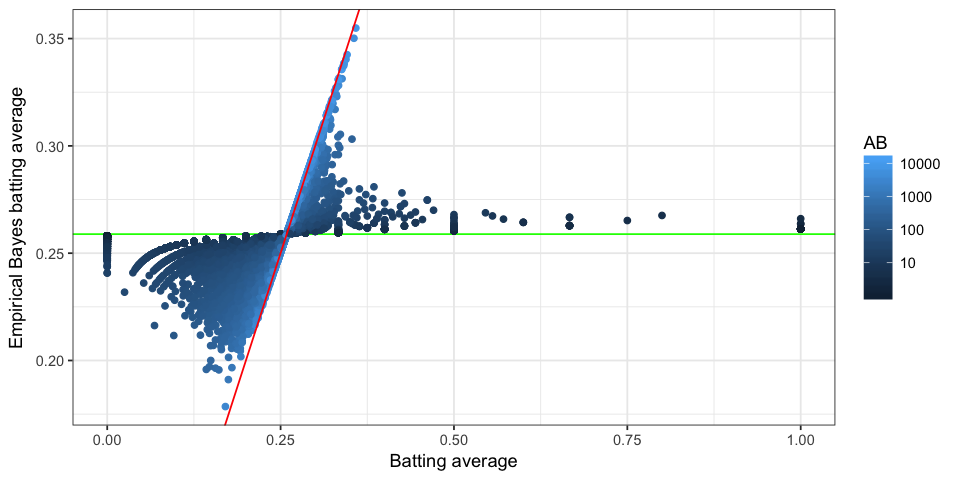

In [293]:
# Visualization to see the impact of empirical bayes on basic BA estimates.
ggplot(data_eb, aes(BA, eb_BA, color = AB)) +
  geom_hline(yintercept = alpha0 / (alpha0 + beta0), color = "green") +
  geom_point() +
  geom_abline(color = "red") +
  scale_colour_gradient(trans = "log", breaks = 10 ^ (1:5)) +
  xlab("Batting average") +
  ylab("Empirical Bayes batting average")

In the above plot, the horizontal green line gives  
 $$y=\frac{\alpha_0}{\alpha_0 + \beta_0} = 0.259 $$
 
which, represents the batting average in the absence of any evidence. As we can see from the graph, the points above the green line tend to move down(shrinking) towards it and points below the line tend to move up(shrinking) towards it.

The diagonal red line is $$x=y$$ The points that are in proximity to this line did not shrink by empirical bayes at all. Actually, they are the ones with the highest no. of at-bats. That means they provide enough evidence for us to believe in the basic batting average(BA) estimate.

### Discussion :

In this journal entry, I used overall distribution of data to estimate a prior and then computed batting average for each player using that prior information.  

Moreover, I derived the prior information using the data from players with more than 500 at-bats. Rather, I should have used all the data to estimate the prior distribution giving more consideration to player's with higher no. of at-bats. I would like to perform more practical version of this estimation in future by implementing dbetabinom.ab function from VGAM library and maximum likelihood function.

